In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
home_dir = op.abspath('./')

#plotting settings
fontsize = 18
ticksize = fontsize*.8
sns.set_context('talk')
sns.__version__

'0.13.2'

In [3]:
bad_subs = ['Da216','Da220','Da395']

In [4]:
artery = op.join(home_dir,
                'niftis',
                 'vesselProbabilities_3mm_susan_8.nii.gz')
artery = nb.load(artery).get_fdata()



mask_dir = op.join(home_dir,
                      'niftis',
                      'shell_analysis')
mask_ids = {'nacc_3mm':0,
            'nacc_caud_1':1,
            'nacc_caud_2':2,
            'nacc_caud_3':3,
           'nacc_put_1':1,
            'nacc_put_2':2,
            'nacc_put_3':3}
masks = {}
for mask in mask_ids.keys():
    if 'caud' in mask:
        
        masks[mask] = nb.load(op.join(mask_dir,
                            mask + '.nii.gz')).get_fdata().astype(bool)
    else:
        masks[mask] = nb.load(op.join(mask_dir,
                            mask + '.nii.gz')).get_fdata().astype(bool)

    

### load data for top plot

In [5]:
shell_df = pd.read_csv('./csvs/shell_data_dopa.csv')
shell_df = shell_df[shell_df['drug'] == 'plac']
print(len(set(shell_df['sub'])))

for bad_sub in bad_subs:
    shell_df = shell_df[shell_df['sub'] !=bad_sub]
print(len(set(shell_df['sub'])))


76
73


### load data for bottom left plot

In [6]:
#load arterial data for figure
art_df = pd.read_csv('./csvs/artery_data.csv')
art_df = art_df[art_df['drug'] == 'plac']

print(len(set(art_df['sub'])))
for bad_sub in bad_subs:
    art_df = art_df[art_df['sub'] !=bad_sub]
print(len(set(art_df['sub'])))


76
73


### load data for bottom middle plot

In [7]:
artery_spatial = []
for mask in mask_ids.keys():
                
    if mask == 'nacc_3mm':
        roi = 'NAcc'
    elif 'caud' in mask:
        roi = 'Caudate'
    elif 'put' in mask:
        roi = 'Putamen'
                                    
    median= np.median(artery[masks[mask]])


    sub_df = pd.DataFrame({
                          'mask':roi,
                          'artery':median,
                           'distance':mask_ids[mask]
                          }, index = [0])
    artery_spatial.append(sub_df)
artery_spatial = pd.concat(artery_spatial)

In [8]:
colors = ['#026C6D',
          '#FF8A8A', 
        '#FFB1B1',
        '#FFD8D8']


### load data for bottom right plot

In [9]:
mask_map = {'nacc':'NAcc',
           'caudate':'Caudate',
           'putamen':'Putamen',
           'S1':'S1',
           'OT':'OTC'}
lag_df = pd.read_csv('./csvs/striatum_region_lag_data.csv')
lag_df['mask'] = [mask_map[x] for x in lag_df['mask']]

print(len(set(lag_df['sub'])))
for bad_sub in bad_subs:
    lag_df = lag_df[lag_df['sub'] !=bad_sub]
print(len(set(lag_df['sub'])))


76
73


In [10]:
artery_regional = []

mask_dir = op.join(home_dir,
                      'niftis',
                      'shell_analysis')

mask_ids = {'nacc_3mm':'NAcc',
            'putamen_3mm':'Putamen',
            'caudate_3mm':'Caudate'}


regional_mask = []

for mask in mask_ids.keys():
        
    mask_bool = nb.load(op.join(mask_dir,
                            mask + '.nii.gz')).get_fdata().astype(bool)
    
    median= np.median(artery[mask_bool])
        
    sub_df = pd.DataFrame({
                           'mask':mask_ids[mask],
                           'artery':median,
                           }, index = [0])
    regional_mask.append(sub_df.copy())
regional_mask = pd.concat(regional_mask)

In [11]:
msc_lags = pd.read_csv('./csvs/scrubbed_MSC.csv')

### Make figure


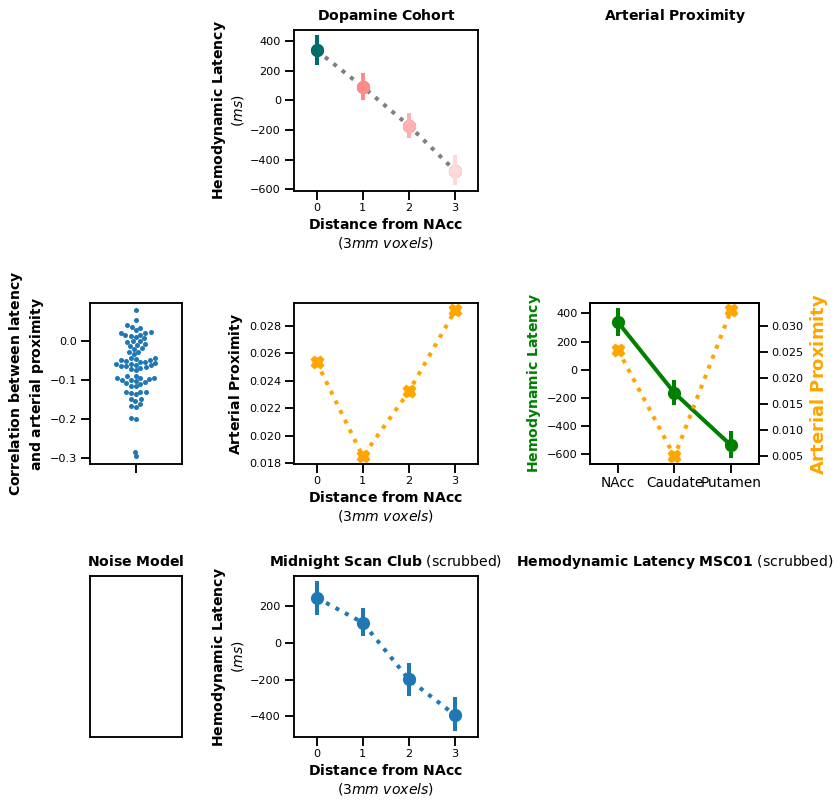

In [12]:
#plotting settings
plt.rcParams['axes.titlepad'] = 10

fontsize = 14
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize


fig,ax=plt.subplots(3,3,
                    figsize=(12,13),
                    width_ratios=[1.5, 3,2.75],
                    sharex=False,
                    sharey=False)

for i in range(3):
    for j in range(3):
        ax[i][j].tick_params(labelsize=ticksize)
        ax[i][j].xaxis.get_label().set_fontsize(fontsize)
        ax[i][j].yaxis.get_label().set_fontsize(fontsize)

##################
####Top Middle######
##################

sns.pointplot(x = 'distance',
             y = 'lag',
              color = 'grey',
             errorbar = None,
              linestyles=':',
                   ax = ax[0][1],
             data = shell_df)

sns.pointplot(x = 'distance',
             y = 'lag',
             errorbar=('ci', 68),
              hue = 'distance',
              palette = colors,
            legend = False,
             data = shell_df,
             ax = ax[0][1])

ax[0][1].set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '$\\bf{Distance\ from\ NAcc}$\n$\it{(3mm\ voxels)}$')

ax[0][1].set_title('$\\bf{Dopamine\ Cohort}$', fontsize=fontsize)
##################
###Middle Left#####
##################

sns.swarmplot(
             y = 'corr',
    ax = ax[1][0],
    data = art_df)
ax[1][0].set(ylabel = '$\\bf{Correlation\ between\ latency}$\n$\\bf{and\ arterial\ proximity}$')
            
##################
####Middle Middle#
##################
a = artery_spatial.groupby('distance')['artery'].mean().reset_index()
sns.pointplot(x = 'distance',
             y = 'artery',
              markers ='X',
                            linestyles=':',
              color = 'orange',
              ax = ax[1][1],
             data = a)

ax[1][1].set(ylabel = '$\\bf{Arterial\ Proximity}$',
            xlabel = '$\\bf{Distance\ from\ NAcc}$\n$\it{(3mm\ voxels)}$')

##################
####Middle Right###
##################
g = sns.pointplot(x = 'mask',
             y = 'lag',
             errorbar=('ci', 68),
              order = ['NAcc','Caudate','Putamen'],
              color= 'green',
              ax = ax[1][2],
             data = lag_df)
ax[1][2].set(xlabel = '',
            ylabel = '$\\bf{Hemodynamic\ Latency}$')
ax[1][2].tick_params(axis = 'x',
                    labelsize=fontsize*.97)
ax[1][2].yaxis.label.set_color('green')

ax2 = g.twinx()

sns.pointplot(x = 'mask',
             y = 'artery',
             errorbar=('ci', 0),
              markers = 'X',
              color = 'orange',
              linestyles=':',
              ax= ax2,
             data = regional_mask)
ax2.set(ylabel ='$\\bf{Arterial\ Proximity}$')
ax2.yaxis.get_label().set_color('orange')
ax2.tick_params(axis = 'y',
                    labelsize=ticksize)

##################
####Bottom Middle###
##################
sns.pointplot(x = 'distance',
             y = 'lag',
             errorbar =('ci', 68),
              linestyles=':',
                   ax = ax[2][1],
             data = msc_lags)
ax[2][1].set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '$\\bf{Distance\ from\ NAcc}$\n$\it{(3mm\ voxels)}$',
            )
ax[2,1].set_title('$\\bf{Midnight\ Scan\ Club}$ (scrubbed)',
                  fontsize=fontsize)



ax[2,0].set_title('$\\bf{Noise\ Model}$',
                  fontsize=fontsize)
ax[0,0].axis('off')
ax[0,2].axis('off')
ax[2,0].set_xticks([], [])
ax[2,0].set_yticks([], [])
ax[2,2].axis('off')
ax[0,2].set_title('$\\bf{Arterial\ Proximity}$',
                  fontsize=fontsize)
ax[2,2].set_title('$\\bf{Hemodynamic\ Latency\ MSC01}$ (scrubbed)',
                  fontsize=fontsize)

plt.subplots_adjust(hspace = .7,
                   wspace= .75)
# plt.savefig('../figs/paper/fig1_figs.png',
#                             bbox_inches = 'tight',
#             dpi = 300)

# Statistical analyses

In [13]:
#lag as a function of distance
md = smf.mixedlm("lag ~ distance", 
                 shell_df,
                 groups=shell_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM  Dependent Variable:  lag        
No. Observations:   292      Method:              REML       
No. Groups:         73       Scale:               171064.9913
Min. group size:    4        Log-Likelihood:      -2241.7048 
Max. group size:    4        Converged:           Yes        
Mean group size:    4.0                                      
-------------------------------------------------------------
            Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    350.176   77.823   4.500 0.000  197.645  502.707
distance    -269.739   21.649 -12.460 0.000 -312.170 -227.308
Group Var 322377.349  169.708                                
=============================================================

"""

In [14]:
#lag as a function of distance when controlling for artery
a = artery_spatial.groupby('distance')['artery'].mean().reset_index()

fig_df = pd.merge(shell_df,
        a,
        on= 'distance')

md = smf.mixedlm("lag ~  distance + artery", 
                 fig_df,
                 groups=fig_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM   Dependent Variable:   lag        
No. Observations:    292       Method:               REML       
No. Groups:          73        Scale:                171634.4273
Min. group size:     4         Log-Likelihood:       -2231.7776 
Max. group size:     4         Converged:            Yes        
Mean group size:     4.0                                        
----------------------------------------------------------------
            Coef.    Std.Err.    z    P>|z|   [0.025     0.975] 
----------------------------------------------------------------
Intercept    431.279  172.712   2.497 0.013     92.770   769.789
distance    -263.743   24.498 -10.766 0.000   -311.758  -215.728
artery     -3745.109 7119.223  -0.526 0.599 -17698.529 10208.312
Group Var 322234.995  169.523                                   
================================================================

"""

In [15]:
#regional NAcc differences
fig_df = pd.merge(regional_mask,
                  lag_df,
                  on = 'mask')
md = smf.mixedlm("lag ~  C(mask,  Treatment(reference='NAcc'))", 
                 fig_df,
                 groups=fig_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
====================================================================================================
Model:                           MixedLM               Dependent Variable:               lag        
No. Observations:                219                   Method:                           REML       
No. Groups:                      73                    Scale:                            226208.0260
Min. group size:                 3                     Log-Likelihood:                   -1700.6229 
Max. group size:                 3                     Converged:                        Yes        
Mean group size:                 3.0                                                                
----------------------------------------------------------------------------------------------------
                                                  Coef.    Std.Err.    z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------------------------------
Intercept                                          336.843   83.539   4.032 0.000   173.109  500.577
C(mask, Treatment(reference='NAcc'))[T.Caudate]   -502.601   78.724  -6.384 0.000  -656.898 -348.305
C(mask, Treatment(reference='NAcc'))[T.Putamen]   -873.908   78.724 -11.101 0.000 -1028.204 -719.611
Group Var                                       283243.633  153.919                                 
====================================================================================================

"""

In [16]:
#lags correlation with arterial proximity
art_df['corr_fisher'] = [np.arctanh(x) for x in art_df['corr']]
scipy.stats.ttest_1samp(art_df['corr_fisher'],0)

md = smf.ols("corr_fisher ~  1", 
                 art_df).fit()
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            corr_fisher   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 07 Jan 2025   Prob (F-statistic):                nan
Time:                        12:24:32   Log-Likelihood:                 86.698
No. Observations:                  73   AIC:                            -171.4
Df Residuals:                      72   BIC:                            -169.1
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0674      0.009     -7.749      0.000      -0.085      -0.050
==============================================================================
Omnibus:                        8.844   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.514
Skew:                          -0.707   Prob(JB):                       0.0142
Kurtosis:                       3.896   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
np.mean(art_df['corr'])

-0.06682879646343097